In [1]:
from util import *
import correlation

In [2]:
def unnormalise_and_convert_mapping_to_flow(map):
    # here map is normalised to -1;1
    # we put it back to 0,W-1, then convert it to flow
    B, C, H, W = map.size()
    mapping = torch.zeros_like(map)
    # mesh grid
    mapping[:,0,:,:] = (map[:, 0, :, :].float().clone() + 1) * (W - 1) / 2.0 # unormalise
    mapping[:,1,:,:] = (map[:, 1, :, :].float().clone() + 1) * (H - 1) / 2.0 # unormalise

    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if mapping.is_cuda:
        grid = grid.cuda()
    flow = mapping - grid
    return flow

In [3]:
class CorrespondenceMapBase(nn.Module):
    def __init__(self, in_channels, bn=False):
        super().__init__()

    def forward(self, x1, x2=None, x3=None):
        x = x1
        # concatenating dimensions
        if (x2 is not None) and (x3 is None):
            x = torch.cat((x1, x2), 1)
        elif (x2 is None) and (x3 is not None):
            x = torch.cat((x1, x3), 1)
        elif (x2 is not None) and (x3 is not None):
            x = torch.cat((x1, x2, x3), 1)

        return x


class CMDTop(CorrespondenceMapBase):
    def __init__(self, in_channels, bn=False):
        super().__init__(in_channels, bn)
        chan = [128, 128, 96, 64, 32]
        self.conv0 = conv_blck(in_channels, chan[0], bn=bn)
        self.conv1 = conv_blck(chan[0], chan[1], bn=bn)
        self.conv2 = conv_blck(chan[1], chan[2], bn=bn)
        self.conv3 = conv_blck(chan[2], chan[3], bn=bn)
        self.conv4 = conv_blck(chan[3], chan[4], bn=bn)
        self.final = conv_head(chan[-1])

    def forward(self, x1, x2=None, x3=None):
        x = super().forward(x1, x2, x3)
        x = self.conv4(self.conv3(self.conv2(self.conv1(self.conv0(x)))))
        return self.final(x)
def conv_blck(in_channels, out_channels, kernel_size=3,
              stride=1, padding=1, dilation=1, bn=False):
    if bn:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
                                       stride, padding, dilation),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True))
    else:
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size,
                                       stride, padding, dilation),
                             nn.ReLU(inplace=True))


def conv_head(in_channels):
    return nn.Conv2d(in_channels, 2, kernel_size=3, padding=1)


In [4]:
def warp5(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo
    # makes a mapping out of the flow
   
  
    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0
    
    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid)
    

    return output 

In [5]:
def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=True)

def conv(in_planes, out_planes, kernel_size=3, stride=1, padding=1, dilation=1, batch_norm=False):
    if batch_norm:
        return nn.Sequential(
                            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                                        padding=padding, dilation=dilation, bias=True),
                            nn.BatchNorm2d(out_planes),
                            nn.LeakyReLU(0.1, inplace=True))
    else:
        return nn.Sequential(
                            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, bias=True),
                            nn.LeakyReLU(0.1))
class OpticalFlowEstimator(nn.Module):

    def __init__(self, in_channels, batch_norm):
        super(OpticalFlowEstimator, self).__init__()

        dd = np.cumsum([128,128,96,64,32])
        self.conv_0 = conv(in_channels, 128, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv_1 = conv(in_channels + dd[0], 128, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv_2 = conv(in_channels + dd[1], 96, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv_3 = conv(in_channels + dd[2], 64, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv_4 = conv(in_channels + dd[3], 32, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.predict_flow = predict_flow(in_channels + dd[4])

    def forward(self, x):
        # dense net connection
        x = torch.cat((self.conv_0(x), x),1)
        x = torch.cat((self.conv_1(x), x),1)
        x = torch.cat((self.conv_2(x), x),1)
        x = torch.cat((self.conv_3(x), x),1)
        x = torch.cat((self.conv_4(x), x),1)
        flow = self.predict_flow(x)
        return x, flow

In [6]:
#(x-min(x))/(max(x)-min(x))
def closure():
    global i
    #out=net(x1=net_input,x3=init_map) #CMDTOP
    x,out=net(net_input) #predict flow
    
    
    
    Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
    Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
    Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
    Warped_feature=warp5(feature_A,Matching_feature_field)
    
   
    Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

    Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
    Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    Warped_image=warp5(I1.detach(),Matching_image_field)

    
    
    loss_1=mse(I2.detach(),Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if i % 200 == 0:
        

   # if epoch % 10000 == 0:
       # print(loss_1)
       # print(loss_2)
        warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
        src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
        tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(src_np)
        axs[0].set_title('src')
        axs[1].imshow(warped_np)
        axs[1].set_title('warped')
        axs[2].imshow(tgt_np)
        axs[2].set_title('tgt')
        '''
        print('Showing results. Close figure window to continue')
       # plt.show()
        fig.savefig(('./result/pretrained_CMD_noise5_pool3/256_3_' + str(i) + '.png'), bbox_inches='tight')
       # im = Image.fromarray(warped_np)
       # im.save('warped'+ str(i)+'.png')
        save_image(Warped_image, './result/pretrained_CMD_noise5_pool3/out_256_3_' +str(i) +'.png')
        '''
    i += 1
    return total_loss
    

In [7]:

def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

# 5. replace z with correlation  map

## 5-1 pretrained feature extractor + DIP


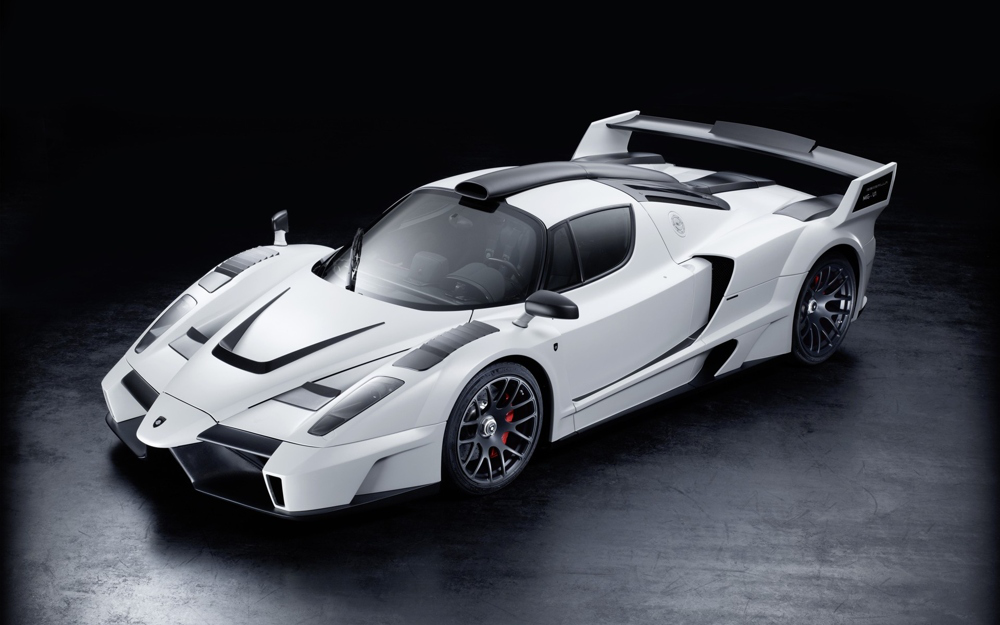

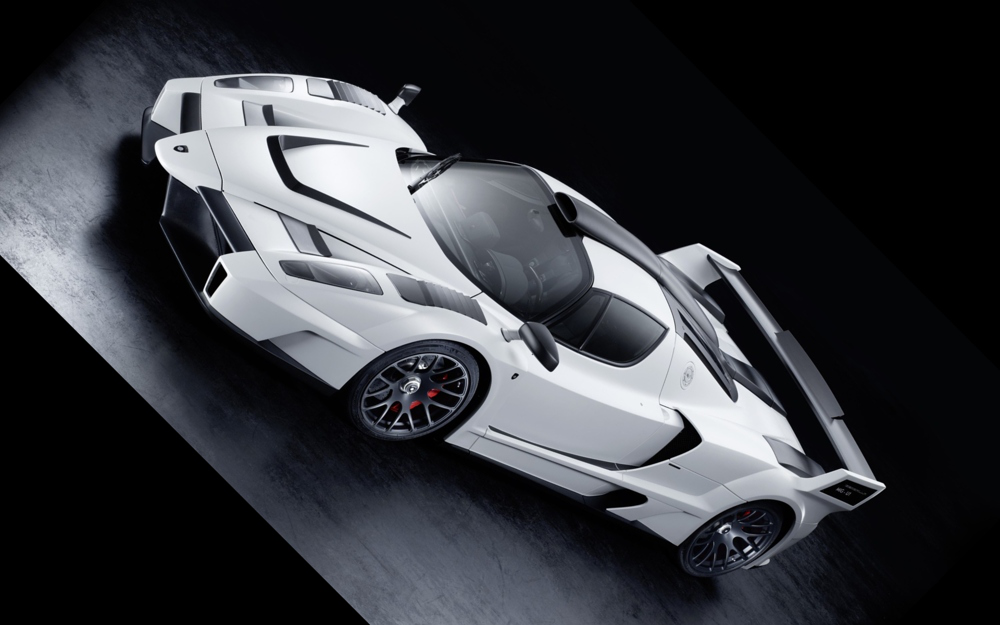

In [8]:
I1,I2=get_image(224,224,"_original.jpg","rotation3.jpg")
FeatureExtraction=FeatureExtraction(train_fe=False,
                                                   feature_extraction_cnn='vgg',
                                                   last_layer='pool2',
                                                   normalization=True,
                                                   use_cuda=True)
FeatureCorrelation = FeatureCorrelation(shape='3D',normalization=True,matching_type='correlation')       
feature_A=FeatureExtraction(I1)
feature_B=FeatureExtraction(I2)
corr = correlation.FunctionCorrelation(feature_A,feature_B)
c = corr.shape[1]
w,h=feature_A.shape[2],feature_A.shape[3]

Starting optimization with ADAM


/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


KeyboardInterrupt: 

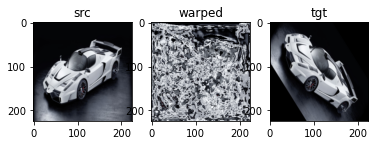

In [9]:
i=0
init_map = torch.FloatTensor(1, 2, w, h).zero_().cuda()
in_chan=c
dtype = torch.cuda.FloatTensor
mse = torch.nn.MSELoss().type(dtype)
#net=CMDTop(in_chan,bn=True).cuda()
net=OpticalFlowEstimator(in_chan,batch_norm=True).cuda()
net_input=corr.detach()
p = get_params('net', net, correlation)

optimize('adam', p, closure, 0.001, 5000)

In [ ]:
#CMDTop +warp5 + pool5 + global corr
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(x1=net_input,x3=init_map)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
Warped_feature=warp5(feature_A,Matching_feature_field)
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


In [ ]:
#CMDTop +warp5 + pool2 +global corr
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(x1=net_input,x3=init_map)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
Warped_feature=warp5(feature_A,Matching_feature_field)
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


In [ ]:
#CMDTop +warp5 + pool2 + local corr
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(x1=net_input,x3=init_map)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
Warped_feature=warp5(feature_A,Matching_feature_field)
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


In [ ]:
#estimate_flow +warp5 + pool2 + local corr
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


a,out=net(net_input)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
Warped_feature=warp5(feature_A,Matching_feature_field)
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


## 5-2 scratch model + DIP

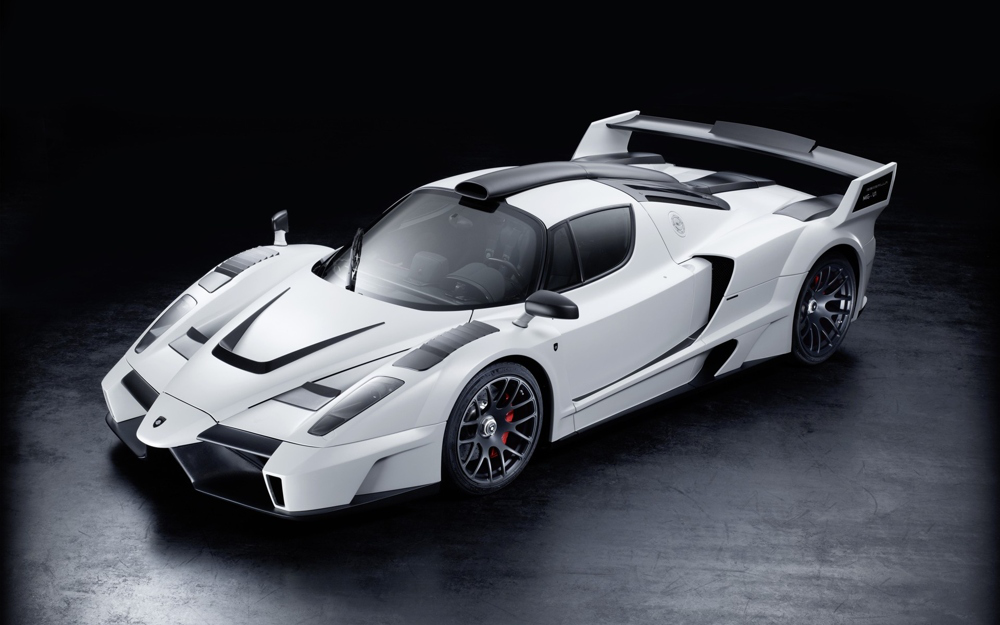

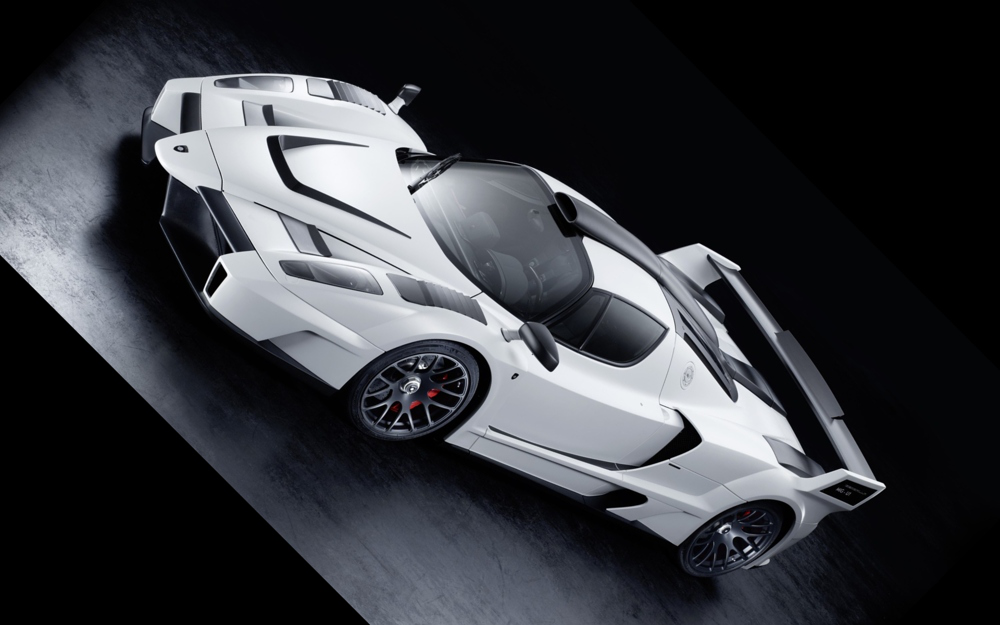

In [12]:
I1,I2=get_image(224,224,"_original.jpg","rotation3.jpg")
last_layer='pool2'
model = models.vgg16(pretrained=False)
            # keep feature extraction network up to indicated layer
vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
if last_layer=='':
        last_layer = 'pool3'

last_layer_idx = vgg_feature_layers.index(last_layer)
model = nn.Sequential(*list(model.features.children())[:last_layer_idx+1])
model=model.cuda()

with torch.no_grad():
    f1=model(I1)
    f2=model(I2)
    corr = correlation.FunctionCorrelation(f1,f2)

c=corr.shape[1]
in_chan=c+2
w,h=f1.shape[2],f1.shape[3]
net=CMDTop(in_chan,bn=True).cuda()
net_input=corr

dtype = torch.cuda.FloatTensor
init_map = torch.FloatTensor(1, 2, w, h).zero_().cuda()
mse = torch.nn.MSELoss().type(dtype)

optimizer=torch.optim.Adam(net.parameters(),0.001)# matching field
optimizer_feature=torch.optim.Adam(model.parameters(),0.001) #feature extraction

tensor(0.2149, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0050, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0',

<ipython-input-13-61fdf94e72e2>:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3)


tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)


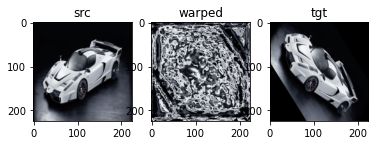

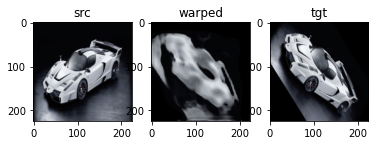

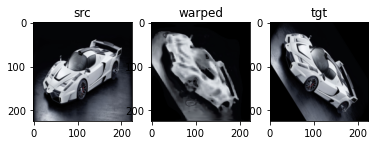

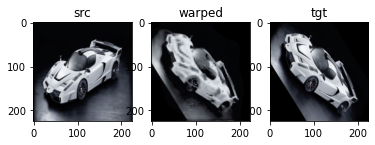

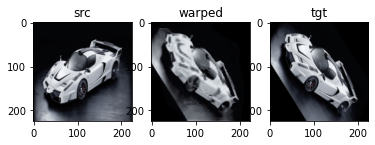

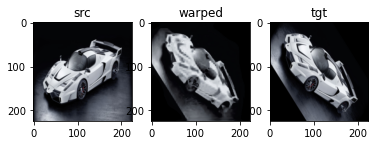

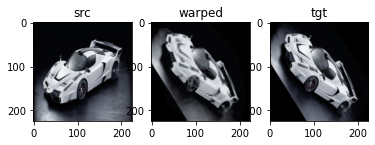

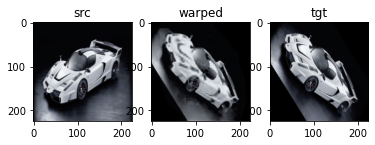

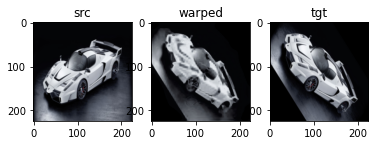

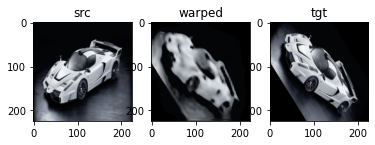

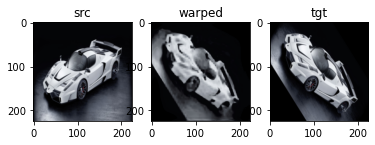

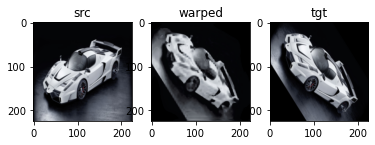

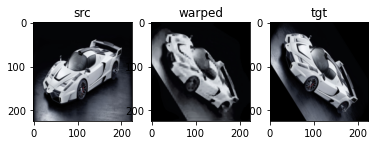

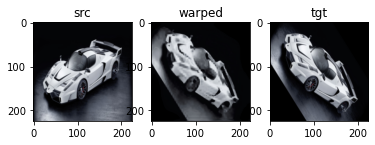

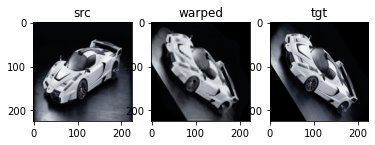

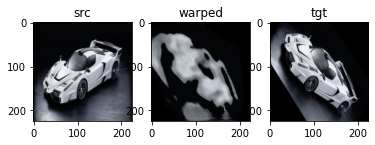

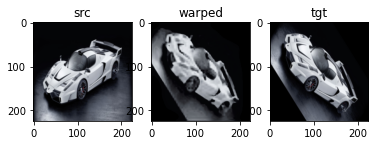

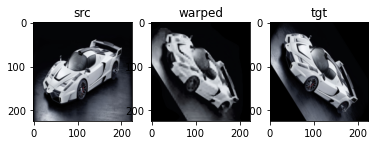

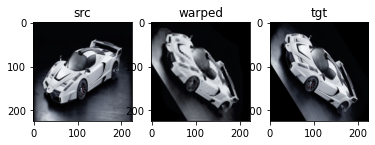

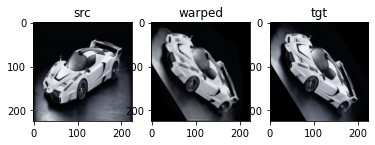

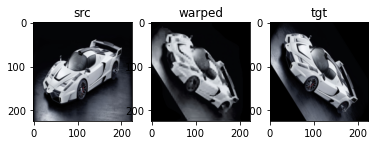

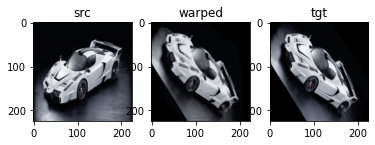

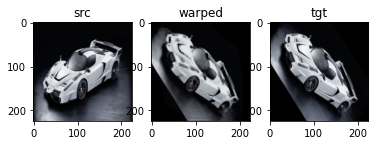

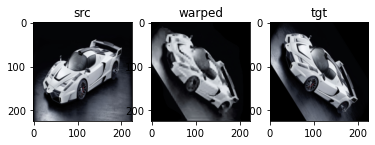

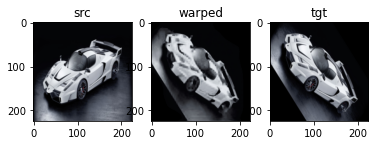

In [13]:
#Training step
global i 
i=0
total_loss=0
init_map = torch.FloatTensor(1, 2, w, h).zero_().cuda().detach()
for epoch in range(5000):
    feature_A = model(I1)
    feature_B = model(I2)
    
    feature_A = featureL2Norm(feature_A)
    feature_B = featureL2Norm(feature_B)
    corr = correlation.FunctionCorrelation(feature_A,feature_B)
    net_input=corr
    out=net(x1=corr,x3=init_map)
    #x,out=net(net_input) #predict flow
    
    
    
    Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
    Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
    Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
    Warped_feature=warp5(feature_A,Matching_feature_field)
    
   
    Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

    Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
    Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    Warped_image=warp5(I1.detach(),Matching_image_field)

    optimizer_feature.zero_grad()
    optimizer.zero_grad()
    loss_1=mse(I2,Warped_image)
    loss_2=mse(feature_B,Warped_feature)
    
    total_loss=loss_1+loss_2
    
    
    
    
    total_loss.backward()
    optimizer_feature.step()
    optimizer.step()
    print ('Iteration %05d    Loss %.10f' % (i, total_loss.item()), '\r', end='')
    if i % 200 == 0:
        print(loss_1)
        print(loss_2)

   # if epoch % 10000 == 0:
       # print(loss_1)
       # print(loss_2)
        warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
        src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
        tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(src_np)
        axs[0].set_title('src')
        axs[1].imshow(warped_np)
        axs[1].set_title('warped')
        axs[2].imshow(tgt_np)
        axs[2].set_title('tgt')
        
    i += 1
    

Text(0.5, 1.0, 'target image')

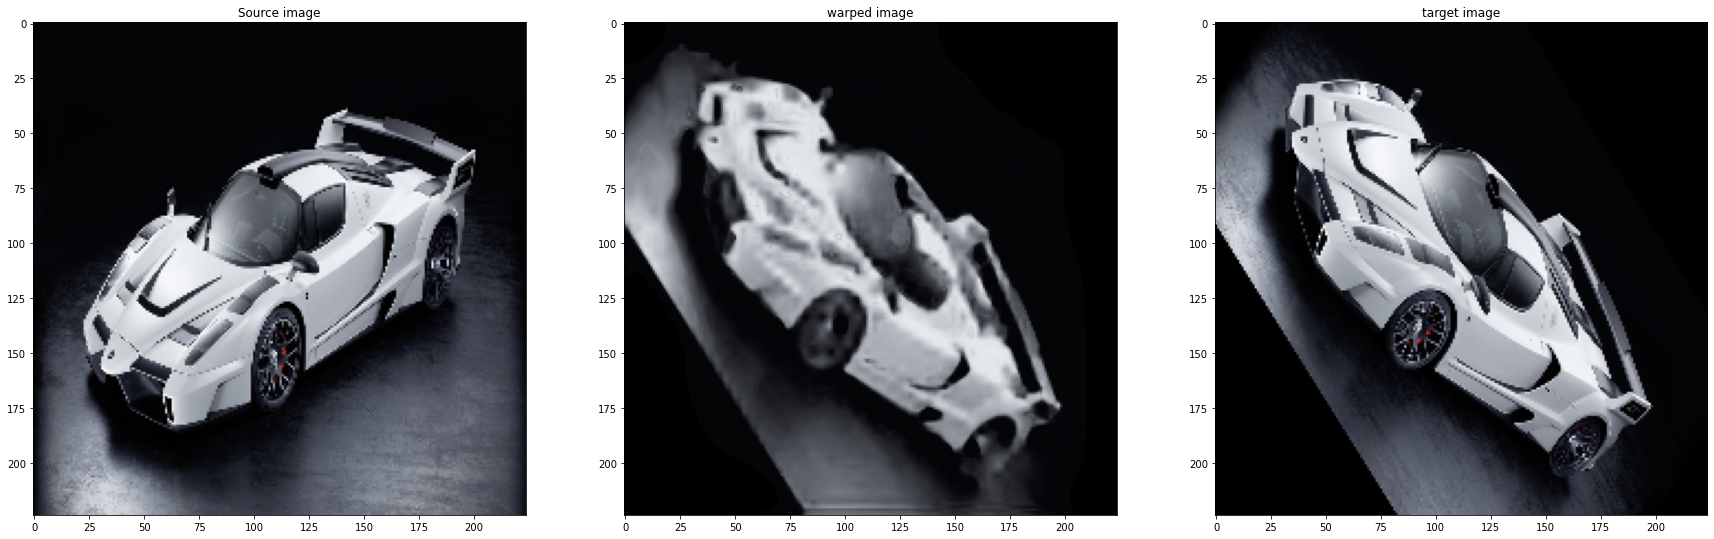

In [14]:
#CMDTop +warp5 + pool2 + local corr
image=imageio.imread('_original.jpg')
image2=imageio.imread('rotation3.jpg')
image=cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
image2=cv2.resize(image2, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


out=net(x1=net_input,x3=init_map)
    
    
    
Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
Warped_feature=warp5(feature_A,Matching_feature_field)
    
Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    
Warped_image=warp5(I1.detach(),Matching_image_field).squeeze(0).transpose(0, 1).transpose(1, 2).detach().cpu().numpy()

#Warped_image=remap_using_flow_fields(image,Matching_image_field.squeeze()[0].detach().cpu().numpy(),Matching_image_field.squeeze()[1].detach().cpu().numpy())
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(30, 30))
axis1.imshow(image)
axis1.set_title('Source image')
axis2.imshow(Warped_image)
axis2.set_title('warped image')
axis3.imshow(image2)
axis3.set_title('target image')
#number 2 0.9 image loss + 0.1 feature loss


## 5-3 contrastive learning + DIP

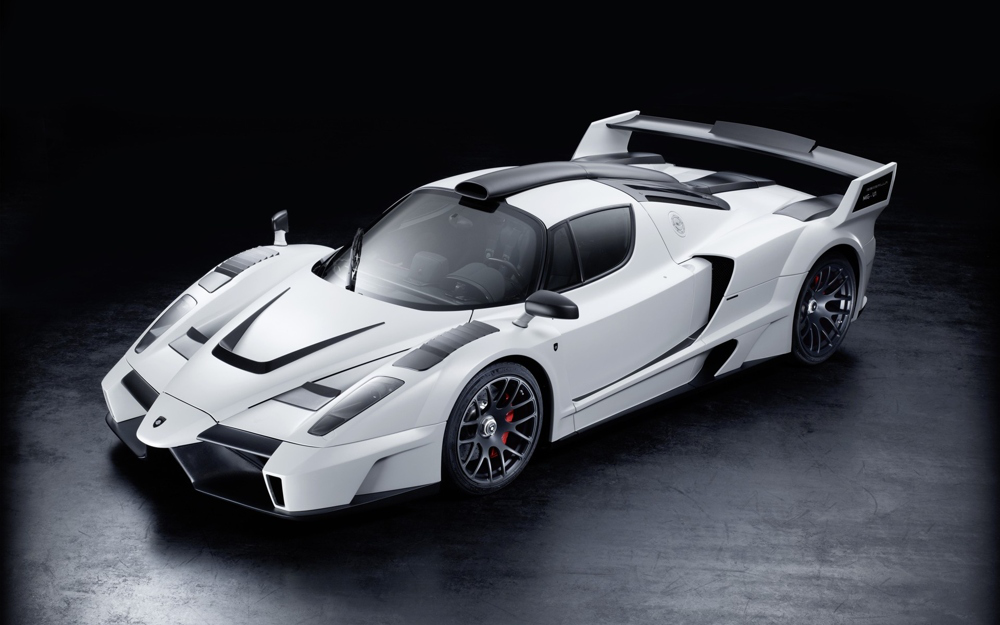

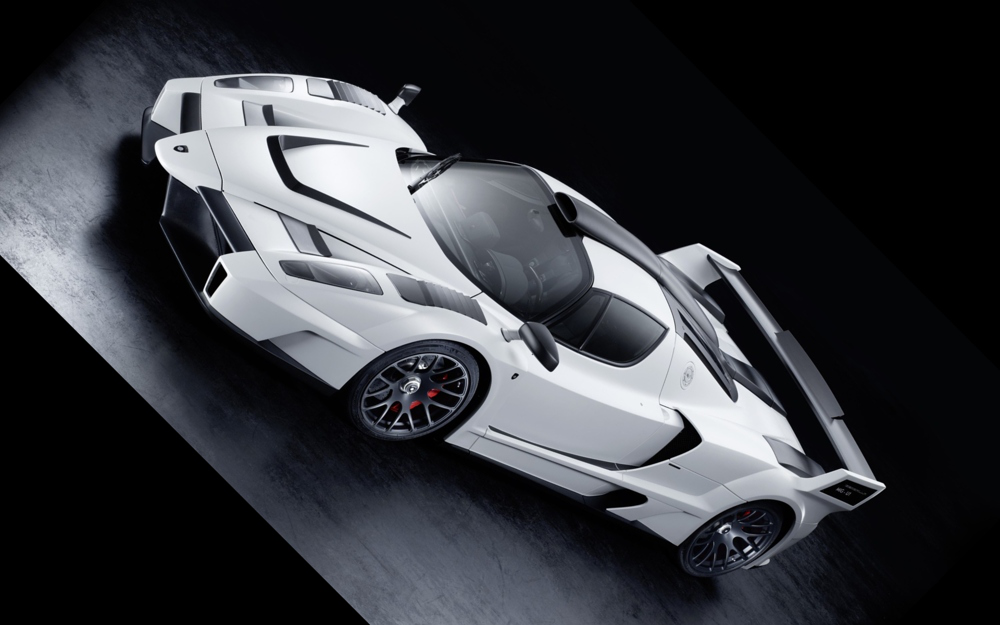

In [5]:
#set up
I1,I2=get_image(224,224,"_original.jpg","rotation3.jpg")
I1.detach()
I2.detach()
last_layer='pool2'
model = models.vgg16(pretrained=False)
            # keep feature extraction network up to indicated layer
vgg_feature_layers=['conv1_1','relu1_1','conv1_2','relu1_2','pool1','conv2_1',
                         'relu2_1','conv2_2','relu2_2','pool2','conv3_1','relu3_1',
                         'conv3_2','relu3_2','conv3_3','relu3_3','pool3','conv4_1',
                         'relu4_1','conv4_2','relu4_2','conv4_3','relu4_3','pool4',
                         'conv5_1','relu5_1','conv5_2','relu5_2','conv5_3','relu5_3','pool5']
if last_layer=='':
        last_layer = 'pool4'
last_layer_idx = vgg_feature_layers.index(last_layer)
model = nn.Sequential(*list(model.features.children())[:last_layer_idx+1])
model=model.cuda()
f1=model(I1)
with torch.no_grad():
    f1=model(I1)
    f2=model(I2)
    corr = correlation.FunctionCorrelation(f1,f2)

c=corr.shape[1]
in_chan=c+2
w,h=f1.shape[2],f1.shape[3]
net=CMDTop(in_chan,bn=True).cuda()
net_input=corr
dtype = torch.cuda.FloatTensor
init_map = torch.FloatTensor(1, 2, w, h).zero_().cuda()
mse = torch.nn.MSELoss().type(dtype)
input_nc=f1.shape[1]
nc=256

mlp = nn.Sequential(*[nn.Linear(input_nc, nc), nn.ReLU(), nn.Linear(nc, nc)]).cuda()

optimizer=torch.optim.Adam(net.parameters(),0.001) # matching field
optimizer_feature=torch.optim.Adam(model.parameters(),0.001) # feature
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1500, gamma=0.1)
scheduler_feature = torch.optim.lr_scheduler.StepLR(optimizer_feature, step_size=1500, gamma=0.1)
I1=I1.cuda()
I2=I2.cuda()
PatchNCE=PatchNCELoss()

#channel = 256

/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ubuntu03/anaconda3/envs/first_env/lib/python3.8/site-packages/torch/nn/functional.py:2970: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


tensor(6.9740, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8328, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0432, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7209, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9822, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6018, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4888, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5621, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5287, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4361, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4826, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4245, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3977, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

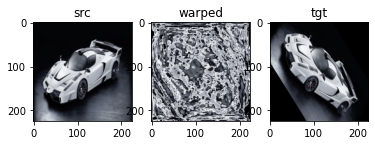

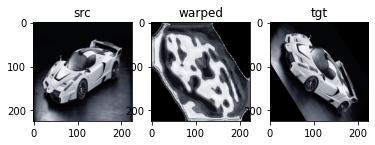

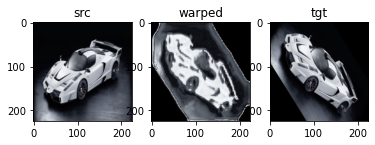

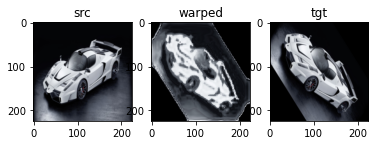

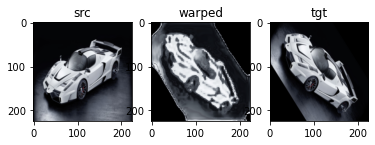

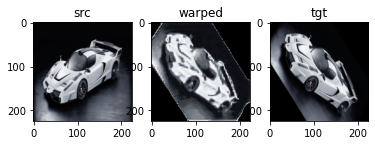

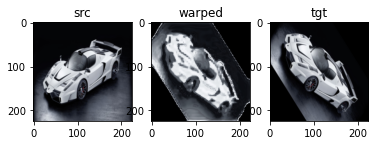

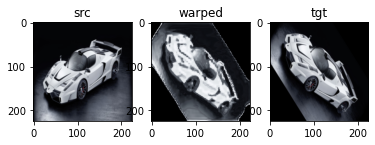

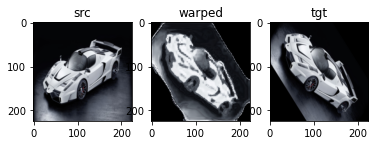

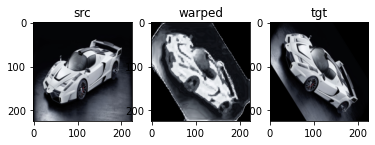

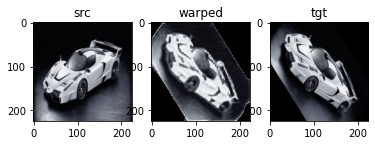

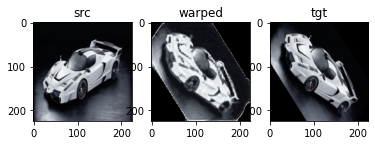

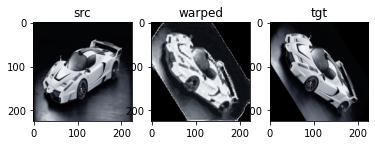

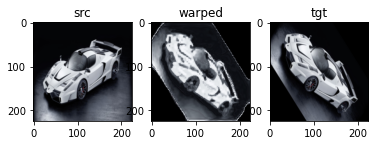

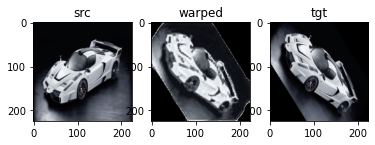

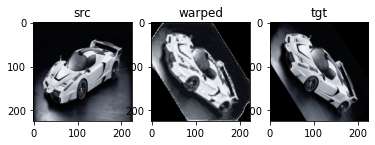

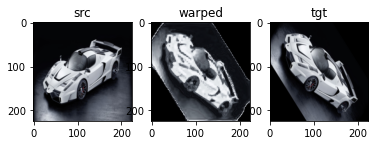

In [6]:
#Training step
#feat = B X  C X H X W
global i 
i=0
for epoch in range(5000):
    feature_A = model(I1)
    
    feature_B = model(I2)
    feature_A=featureL2Norm(feature_A)
    feature_B=featureL2Norm(feature_B)
    # took out l2 norm for feature
    
    corr = correlation.FunctionCorrelation(feature_A,feature_B)
    net_input=featureL2Norm(corr)
    featB_reshape = feature_B.permute(0, 2, 3, 1).flatten(1, 2)
    patch_id = torch.randperm(featB_reshape.shape[1]).cuda()
    patch_id = patch_id[:int(min(1024, patch_id.shape[0]))]  # int vs (h x w) of sample
    B_sample = featB_reshape[:, patch_id, :].flatten(0, 1)  # reshape(-1, x.shape[1])
   
    
    B=mlp(B_sample)
    B=featureL2Norm(B)
    
   
    
    out=net(x1=corr,x3=init_map)
    
    
    
    
    Matching_feature_field=unnormalise_and_convert_mapping_to_flow(out)/1.0
    Matching_feature_field[:, 0, :, :]=Matching_feature_field[:, 0, :, :].clone()*float((I1.shape[2]/w)) 
    Matching_feature_field[:, 1, :, :]=Matching_feature_field[:, 1, :, :].clone()*float((I1.shape[2]/w))
    
    
   
    Matching_image_field=F.interpolate(input=Matching_feature_field, size=(224,224), mode='bilinear')

    Matching_image_field[:, 0, :, :]=Matching_image_field[:, 0, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2])) 
    Matching_image_field[:, 1, :, :]=Matching_image_field[:, 1, :, :].clone()*float(Matching_image_field.shape[2]/(I1.shape[2]))
    Warped_image=warp5(I1.detach(),Matching_image_field)
    
    
   
    featA_reshape=model(Warped_image)
    
    featA_reshape=featureL2Norm(featA_reshape)
    featA_reshape=featA_reshape.permute(0,2,3,1).flatten(1,2)
   
    A_sample= featA_reshape[:,patch_id,:].flatten(0,1)
    
    A=mlp(A_sample)
    A=featureL2Norm(A)
    
   
    optimizer_feature.zero_grad()
    optimizer.zero_grad()
   
    
    loss_2=PatchNCE(A,B).mean()
    print ('Iteration %05d    Loss %f' % (i, loss_2), '\r', end='')
    
    total_loss=loss_2
    
    if i % 200 == 0:
        
        print(loss_2)

   # if epoch % 10000 == 0:
       # print(loss_1)
       # print(loss_2)
        warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
        src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
        tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
        fig, axs = plt.subplots(1, 3)
        axs[0].imshow(src_np)
        axs[0].set_title('src')
        axs[1].imshow(warped_np)
        axs[1].set_title('warped')
        axs[2].imshow(tgt_np)
        axs[2].set_title('tgt')
    
    
    total_loss.backward()
    optimizer_feature.step()
    optimizer.step()
   #print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    scheduler.step()
    scheduler_feature.step()
    i += 1
    

In [ ]:
warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
axs[0].imshow(src_np)
axs[0].set_title('src')
axs[1].imshow(warped_np)
axs[1].set_title('warped')
axs[2].imshow(tgt_np)
axs[2].set_title('tgt')

Text(0.5, 1.0, 'tgt')

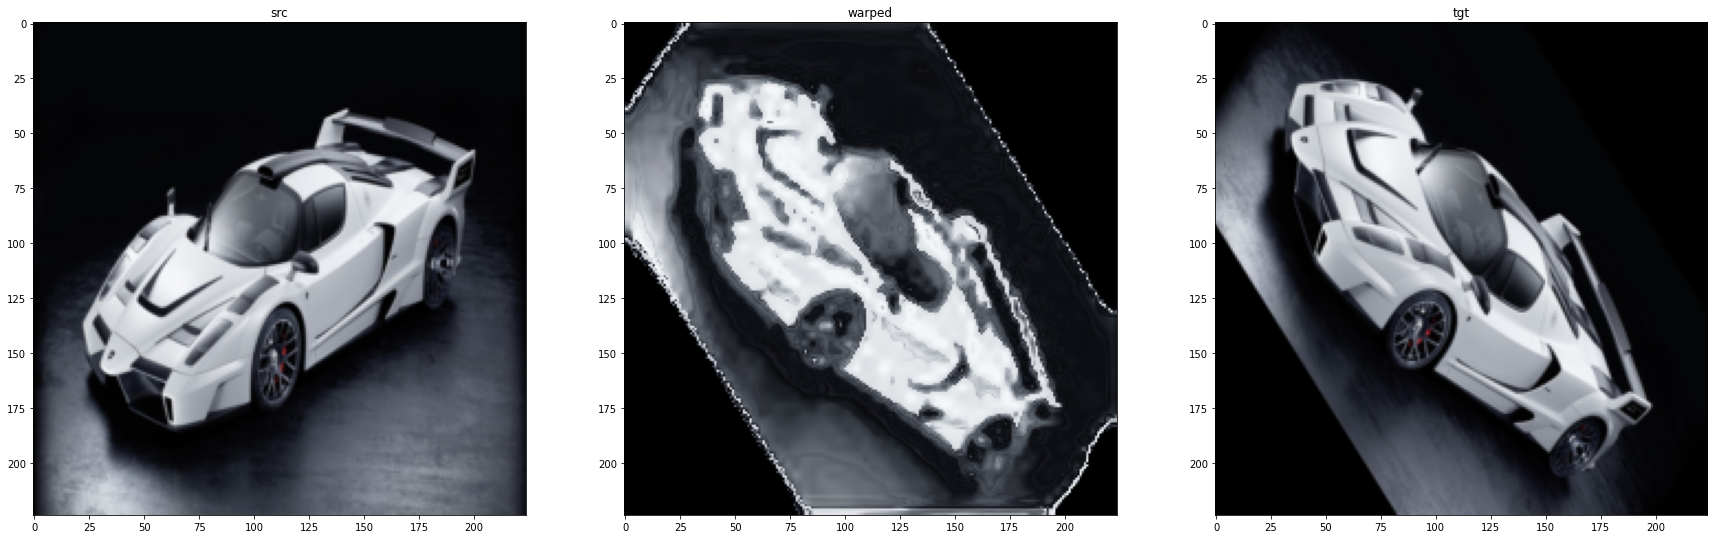

In [7]:
warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
axs[0].imshow(src_np)
axs[0].set_title('src')
axs[1].imshow(warped_np)
axs[1].set_title('warped')
axs[2].imshow(tgt_np)
axs[2].set_title('tgt')

Text(0.5, 1.0, 'tgt')

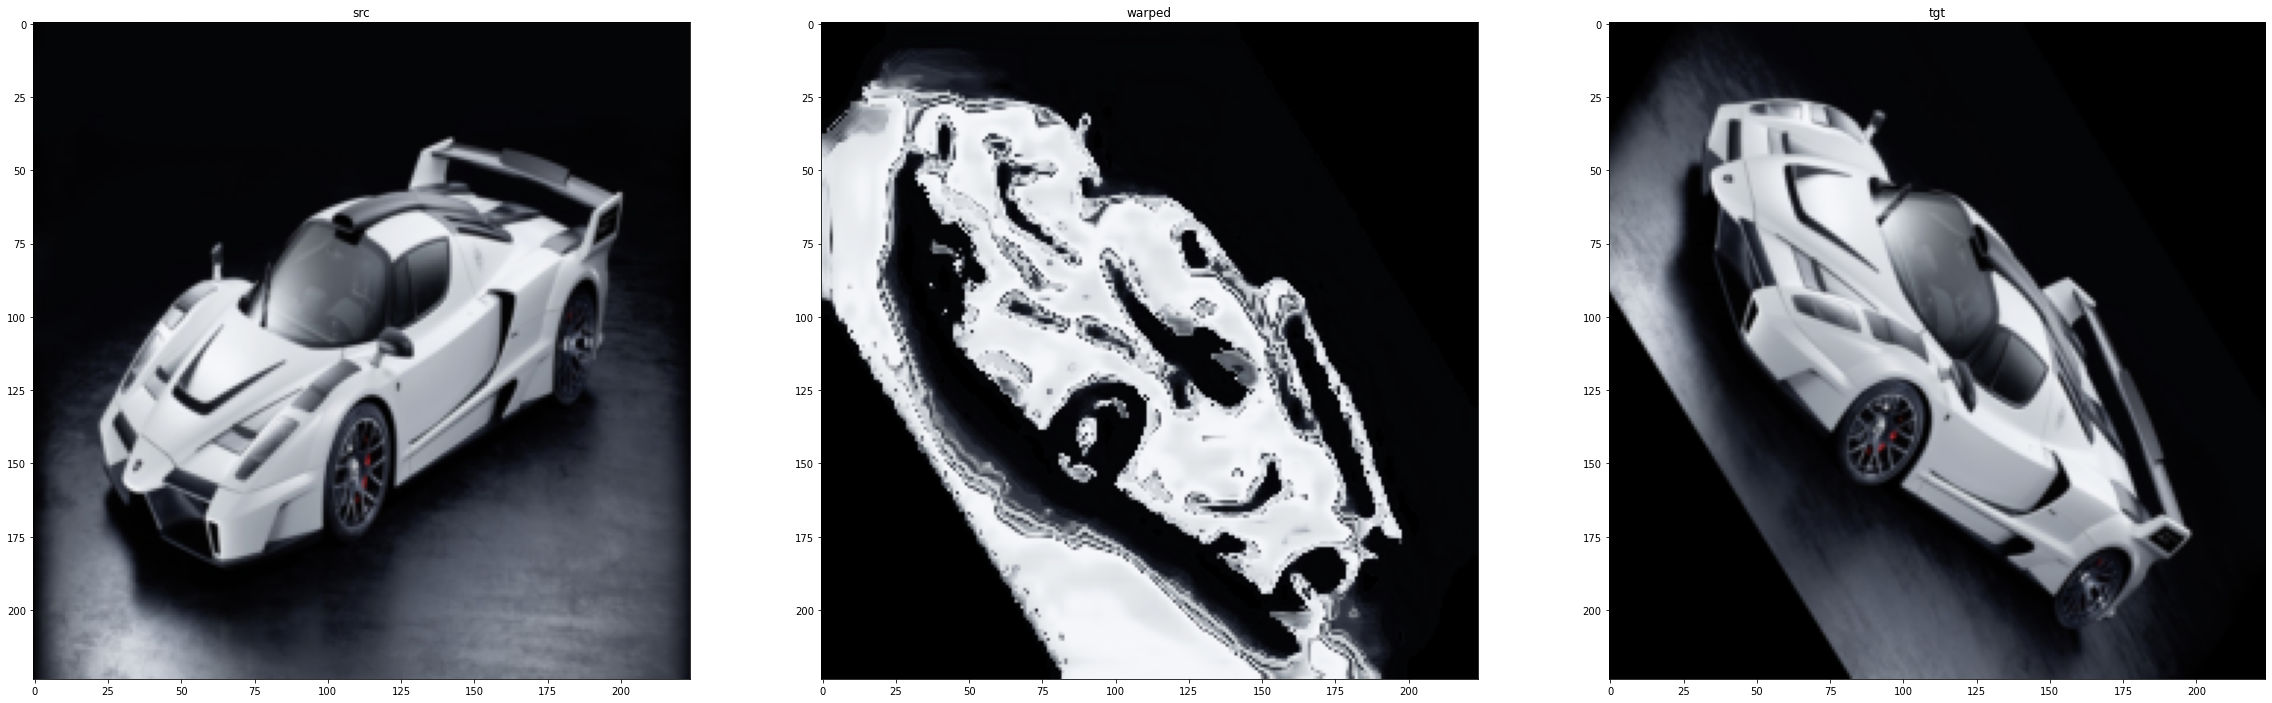

In [13]:
warped_np = Warped_image.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image.permute(0,2,3,1))
        
src_np = I1.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
tgt_np = I2.data.squeeze(0).transpose(0, 1).transpose(1, 2).cpu().numpy()
       # warped_np = torch_to_np(Warped_image)
fig, axs = plt.subplots(1, 3,figsize=(40, 30))
axs[0].imshow(src_np)
axs[0].set_title('src')
axs[1].imshow(warped_np)
axs[1].set_title('warped')
axs[2].imshow(tgt_np)
axs[2].set_title('tgt')